In [1]:
import torch
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GNNExplainer, PGExplainer, GraphLIME, IntegratedGradExplainer, SubgraphX, PGMExplainer
from graphxai.metrics import graph_exp_acc, graph_exp_faith
# from graphxai.visualization import ExplanationVisualizer
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import networkx as nx


# nx.draw()

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, GATConv, GATv2Conv, SAGEConv, global_mean_pool, global_max_pool

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        
        return self.lin(x)


class GIN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GINConv(torch.nn.Linear(in_dim, hidden_dim))
        self.conv2 = GINConv(torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv3 = GINConv(torch.nn.Linear(hidden_dim, hidden_dim))
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch)
        
        return self.lin(x)
    

class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.5):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.conv3 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=False, dropout=dropout)
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        
        x = global_max_pool(x, batch)

        return self.lin(x)


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, aggr='mean')
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.conv3 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.lin = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch)

        return self.lin(x)


In [3]:
in_dim = 14
hidden_dim = 32
out_dim = 2

models = {
    'GIN': GIN(in_dim, hidden_dim, out_dim).to(device),
    'GCN': GCN(in_dim, hidden_dim, out_dim).to(device),
    'GAT': GAT(in_dim, hidden_dim, out_dim).to(device),
    'GraphSAGE': GraphSAGE(in_dim, hidden_dim, out_dim).to(device)
}

In [4]:
from graphxai.datasets import Benzene

data_path = '../GraphXAI/graphxai/datasets/real_world/benzene/benzene.npz'
dataset = Benzene(split_sizes = (0.75, 0.05, 0.2), data_path = data_path, device=device)
batch_size = 64
train_loader = dataset.get_train_loader(batch_size=batch_size)[0]
val_loader = dataset.get_val_loader()[0]
test_loader = dataset.get_test_loader()[0]

In [159]:
torch.cuda.empty_cache()

In [5]:
from graphxai.gnn_models.graph_classification import train, test


for model_name, model in models.items():
    print("\n\t" + model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss().to(device)

    for epoch in range(30):
        train(model, optimizer, criterion, train_loader)
        f1, _, _, _, auc = test(model, val_loader)

        print(f'epoch: {epoch+1:1d}, val F1: {f1:.4f}, val AUC: {auc:.4f}')

    f1, _, _, _, auc = test(model, test_loader)
    print(f'test F1: {f1:.4f}, test AUC: {auc:.4f}')


	GIN
epoch: 1, val F1: 0.7920, val AUC: 0.8329
epoch: 2, val F1: 0.7516, val AUC: 0.8626
epoch: 3, val F1: 0.8010, val AUC: 0.8701
epoch: 4, val F1: 0.8147, val AUC: 0.8737
epoch: 5, val F1: 0.7906, val AUC: 0.8770
epoch: 6, val F1: 0.8251, val AUC: 0.8798
epoch: 7, val F1: 0.8301, val AUC: 0.8852
epoch: 8, val F1: 0.8299, val AUC: 0.8935
epoch: 9, val F1: 0.7170, val AUC: 0.8979
epoch: 10, val F1: 0.8091, val AUC: 0.9061
epoch: 11, val F1: 0.8561, val AUC: 0.9107
epoch: 12, val F1: 0.8364, val AUC: 0.9206
epoch: 13, val F1: 0.8299, val AUC: 0.9241
epoch: 14, val F1: 0.8218, val AUC: 0.9267
epoch: 15, val F1: 0.8693, val AUC: 0.9242
epoch: 16, val F1: 0.8609, val AUC: 0.9264
epoch: 17, val F1: 0.8379, val AUC: 0.9315
epoch: 18, val F1: 0.8413, val AUC: 0.9323
epoch: 19, val F1: 0.8507, val AUC: 0.9343
epoch: 20, val F1: 0.8401, val AUC: 0.9343
epoch: 21, val F1: 0.8507, val AUC: 0.9361
epoch: 22, val F1: 0.8357, val AUC: 0.9384
epoch: 23, val F1: 0.8646, val AUC: 0.9374
epoch: 24, val

d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 8, val F1: 0.0000, val AUC: 0.8340
epoch: 9, val F1: 0.1053, val AUC: 0.8370
epoch: 10, val F1: 0.0149, val AUC: 0.8373
epoch: 11, val F1: 0.0017, val AUC: 0.8601
epoch: 12, val F1: 0.1502, val AUC: 0.8607


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 13, val F1: 0.0000, val AUC: 0.8622


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 14, val F1: 0.0000, val AUC: 0.8585


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch: 15, val F1: 0.0000, val AUC: 0.8597
epoch: 16, val F1: 0.0231, val AUC: 0.8566
epoch: 17, val F1: 0.0100, val AUC: 0.8675
epoch: 18, val F1: 0.0067, val AUC: 0.8739
epoch: 19, val F1: 0.3222, val AUC: 0.8714
epoch: 20, val F1: 0.0067, val AUC: 0.8694
epoch: 21, val F1: 0.4424, val AUC: 0.8716
epoch: 22, val F1: 0.1073, val AUC: 0.8700
epoch: 23, val F1: 0.2507, val AUC: 0.8786
epoch: 24, val F1: 0.3301, val AUC: 0.8802
epoch: 25, val F1: 0.3063, val AUC: 0.8808
epoch: 26, val F1: 0.3331, val AUC: 0.8785
epoch: 27, val F1: 0.2316, val AUC: 0.8728
epoch: 28, val F1: 0.2496, val AUC: 0.8840
epoch: 29, val F1: 0.2573, val AUC: 0.8845
epoch: 30, val F1: 0.5089, val AUC: 0.8810
test F1: 0.5425, test AUC: 0.8978

	GraphSAGE
epoch: 1, val F1: 0.6977, val AUC: 0.7926
epoch: 2, val F1: 0.7930, val AUC: 0.8388
epoch: 3, val F1: 0.7729, val AUC: 0.8450
epoch: 4, val F1: 0.7762, val AUC: 0.8490
epoch: 5, val F1: 0.7724, val AUC: 0.8510
epoch: 6, val F1: 0.7451, val AUC: 0.8531
epoch: 7, val 

In [45]:

for model_name, model in models.items():
    f1, _, _, _, auc = test(model, test_loader)
    print(f"{model_name}: {f1}")

GIN: 0.8848080133555927
GCN: 0.8198347107438017
GAT: 0.3582887700534759
GraphSAGE: 0.830820770519263


In [ ]:
dataset.get_train_list()[0]

In [6]:
from graphxai.explainers import PGExplainer, IntegratedGradExplainer, GNNExplainer, SubgraphX, RandomExplainer, GradCAM, GNN_LRP, PGMExplainer


null_batch = torch.zeros(1).long().cuda()
forward_kwargs = {'batch': null_batch}

explainers = {model_name: {} for model_name in models}

for idx, (name, model) in enumerate(models.items()):
    in_channels = (64 if name in ["GAT","GraphSAGE"] else None)
    pgex = PGExplainer(model, emb_layer_name='conv3', in_channels=in_channels, explain_graph=True, max_epochs=5)
    # pgmex = PGMExplainer(model, explain_graph=True)
    # gradcamex = GradCAM(model, criterion=criterion)
    # gnnlrpex = GNN_LRP(model)
    igex = IntegratedGradExplainer(model, criterion=criterion)
    subex = SubgraphX(model)
    gnnex = GNNExplainer(model)
    rndex = RandomExplainer(model)

    pgex.train_explanation_model(dataset.get_test_list()[0][:500], forward_kwargs=forward_kwargs)

    explainers[name] = {
        "PGExplainer": pgex,
        "GNNExplainer": gnnex,
        # "RandomExplainer": rndex,
        "IntegratedGradExplainer": igex,
        "SubgraphX": subex,
        # "PGMExplainer": pgmex,
        # "GradCAM": gradcamex,
        # "GNN_LRP": gnnlrpex,    
    }


100%|██████████| 500/500 [00:03<00:00, 134.40it/s]


Epoch: 0 | Loss: 114.6046001277864


100%|██████████| 500/500 [00:03<00:00, 138.93it/s]


Epoch: 1 | Loss: 109.83828788995743


100%|██████████| 500/500 [00:03<00:00, 137.92it/s]


Epoch: 2 | Loss: 103.99910198524594


100%|██████████| 500/500 [00:03<00:00, 138.50it/s]


Epoch: 3 | Loss: 96.58103433996439


100%|██████████| 500/500 [00:03<00:00, 137.93it/s]


Epoch: 4 | Loss: 87.73497382551432


100%|██████████| 500/500 [00:04<00:00, 113.88it/s]


Epoch: 0 | Loss: 113.32668202742934


100%|██████████| 500/500 [00:04<00:00, 113.86it/s]


Epoch: 1 | Loss: 111.9782044403255


100%|██████████| 500/500 [00:04<00:00, 114.91it/s]


Epoch: 2 | Loss: 110.38116535544395


100%|██████████| 500/500 [00:04<00:00, 118.63it/s]


Epoch: 3 | Loss: 108.1922517195344


100%|██████████| 500/500 [00:04<00:00, 114.30it/s]


Epoch: 4 | Loss: 105.32354076579213


100%|██████████| 500/500 [00:04<00:00, 102.20it/s]


Epoch: 0 | Loss: 206.46996568888426


100%|██████████| 500/500 [00:04<00:00, 103.40it/s]


Epoch: 1 | Loss: 201.28140641748905


100%|██████████| 500/500 [00:04<00:00, 102.19it/s]


Epoch: 2 | Loss: 194.59480544552207


100%|██████████| 500/500 [00:04<00:00, 101.74it/s]


Epoch: 3 | Loss: 185.67165241390467


100%|██████████| 500/500 [00:04<00:00, 103.21it/s]


Epoch: 4 | Loss: 173.83822187036276


100%|██████████| 500/500 [00:03<00:00, 134.82it/s]


Epoch: 0 | Loss: 116.47060196474195


100%|██████████| 500/500 [00:03<00:00, 138.98it/s]


Epoch: 1 | Loss: 112.07536788284779


100%|██████████| 500/500 [00:03<00:00, 136.44it/s]


Epoch: 2 | Loss: 106.65065268054605


100%|██████████| 500/500 [00:03<00:00, 141.53it/s]


Epoch: 3 | Loss: 99.30069416761398


100%|██████████| 500/500 [00:03<00:00, 140.50it/s]

Epoch: 4 | Loss: 90.95640407502651


In [27]:
test_graph, explanation = dataset.get_test_w_label(1)
test_graph.to('cuda')

model = models['GIN']
out = model(test_graph.x, test_graph.edge_index)
pred = out.argmax(dim=1).item()
true_label = test_graph.y.item()

print(pred)
print(true_label)

tensor([1], device='cuda:0')
1


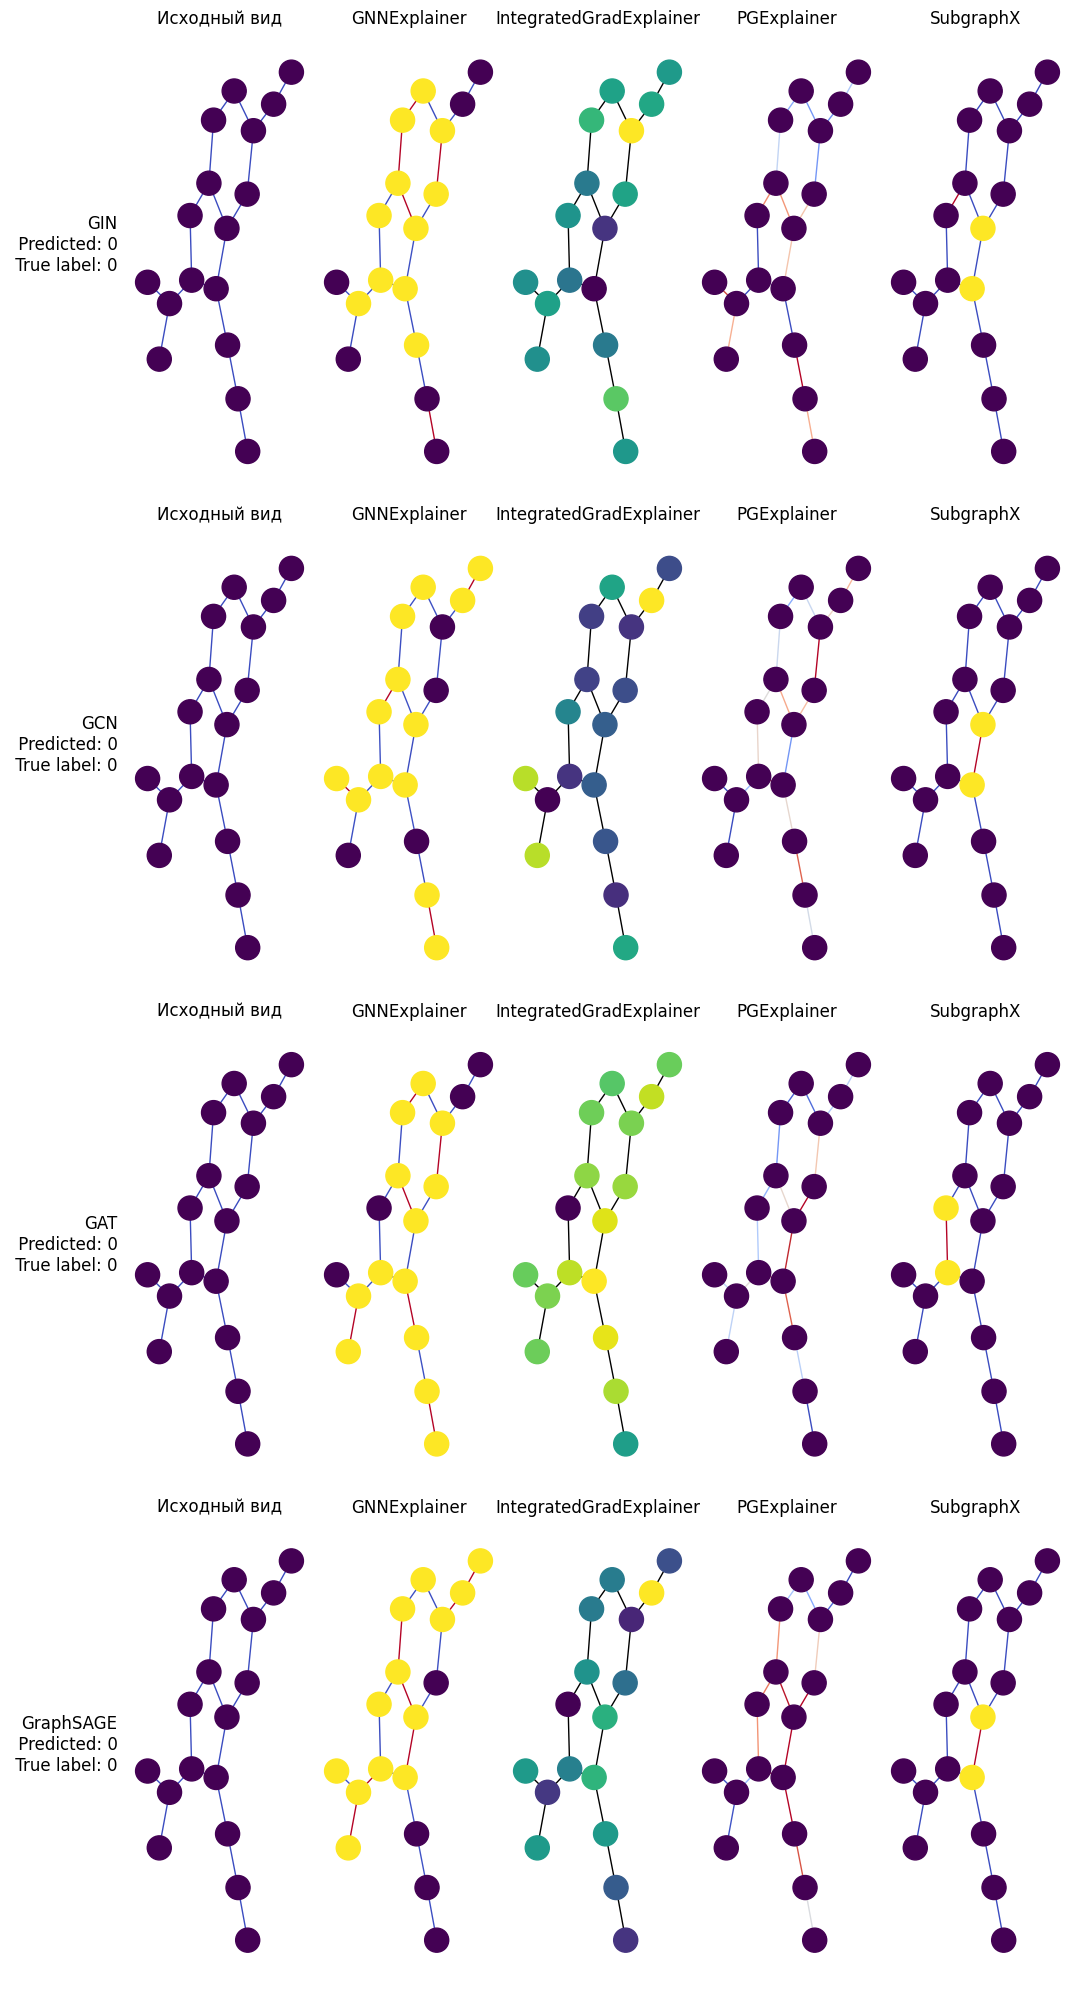

In [29]:
fig, ax = plt.subplots(len(models), 5, figsize = (10, 20))

test_graph, explanation = dataset.get_test_w_label(0)
test_graph.to('cuda')

for idx, (name, model) in enumerate(models.items()):

    pgex, gnnex, igex, subex = explainers[name].values()

    pg_exp = pgex.get_explanation_graph(x=test_graph.x, edge_index=test_graph.edge_index, label=test_graph.y, forward_kwargs = forward_kwargs)
    ig_exp = igex.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index, label=test_graph.y, forward_kwargs=forward_kwargs)
    gnn_exp = gnnex.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index)
    subex_exp = subex.get_explanation_graph(x=test_graph.x, edge_index=test_graph.edge_index, label=test_graph.y, forward_kwargs = forward_kwargs)
    
    ax[idx, 0].set_title('Исходный вид')
    ax[idx, 1].set_title('GNNExplainer')
    ax[idx, 2].set_title('IntegratedGradExplainer')
    ax[idx, 3].set_title('PGExplainer')
    ax[idx, 4].set_title('SubgraphX')

    out = model(test_graph.x, test_graph.edge_index)
    pred = out.argmax(dim=1).item()
    true_label = test_graph.y.item()

    fig.text(0.04, (1 - (idx + 0.5) / len(models)), f"{name}\n Predicted: {pred}\n True label: {true_label}", va='center', ha='right', fontsize=12)

    explanation[0].visualize_graph(ax = ax[idx, 0])
    gnn_exp.visualize_graph(ax = ax[idx, 1])
    ig_exp.visualize_graph(ax = ax[idx, 2])
    pg_exp.visualize_graph(ax = ax[idx, 3])
    subex_exp.visualize_graph(ax = ax[idx, 4])

plt.tight_layout(rect=[0.04, 0, 1, 1])
plt.show()

In [50]:
torch.cuda.empty_cache()

In [55]:
def fidelity(model, explanation, graph, device='cuda'):

    node_mask = explanation.node_imp.to(device)
    edge_mask = explanation.edge_imp.to(device) if explanation.edge_imp != None else None

    y = model(graph.x, graph.edge_index).softmax(dim=1)

    explain_y_hat = model(
        graph.x * node_mask.unsqueeze(-1) if node_mask is not None else graph.x,
        graph.edge_index[:, edge_mask.bool()] if edge_mask is not None else graph.edge_index
    ).softmax(dim=1)

    complement_y_hat = model(
        graph.x * (1 - node_mask).unsqueeze(-1) if node_mask is not None else graph.x,
        graph.edge_index[:, ~(edge_mask.bool())] if edge_mask is not None else graph.edge_index
    ).softmax(dim=1)

    pos_fidelity = 1.0 - (complement_y_hat == y).float().mean()
    neg_fidelity = 1.0 - (explain_y_hat == y).float().mean()

    return float(pos_fidelity), float(neg_fidelity)



def characterization_score( pos_fidelity, neg_fidelity, pos_weight=0.5, neg_weight=0.5):
    eps = 1e-9
    denom = (pos_weight / (pos_fidelity + eps)) + (neg_weight / (1. - neg_fidelity + eps))
    return 1. / denom

In [69]:
# test_graph, explanation = dataset.get_test_w_label(1)
# test_graph.to('cuda')
# model_name = "GraphSAGE"

import numpy as np
from graphxai.metrics.metrics_graph import graph_exp_acc_graph, graph_exp_faith_graph

graphs, explanations = dataset.get_data_list(dataset.test_index)

# scores = {model_name:{explainer:{} for explainer in explainers[model_name]} for model_name in models}

for model_name in models:
    print()
    print(model_name)
    for exp_name, explainer in explainers[model_name].items():
        if exp_name != "IntegratedGradExplainer":
            continue
        characterization = 0
        accuracy = np.zeros(3)
        faithfulness = np.zeros(3)

        num_graphs = 1000 if exp_name in ['PGExplainer'] else 10
        num_graphs = 5 if exp_name == "SubgraphX" else num_graphs

        for test_graph, explanation in zip(graphs[:num_graphs], explanations[:num_graphs]):
            

            if exp_name in ["GNNExplainer", "RandomExplainer", "PGMExplainer"]:
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index)
            else:
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index, label=test_graph.y, forward_kwargs=forward_kwargs)

            try:
                pos_fid, neg_fid = fidelity(models[model_name], gen_exp, test_graph)
            except:
                continue
            
            # print(pos_fid, neg_fid)
            characterization += characterization_score(pos_fid, neg_fid)
            
            acc_feat, acc_nodes, acc_edges = graph_exp_acc_graph(explanation, gen_exp)
            accuracy += [acc_feat if acc_feat != None else 0, acc_nodes, acc_edges if acc_edges else 0]

            faith_feat, faith_nodes, faith_edges = graph_exp_faith_graph(gen_exp, test_graph, models[model_name])
            faithfulness += [faith_feat if faith_feat != None else 0, faith_nodes, faith_edges if faith_edges else 0]

        characterization /= num_graphs
        accuracy /= num_graphs
        faithfulness /= num_graphs
        
        scores[model_name][exp_name]['characterization_score'] = characterization
        scores[model_name][exp_name]['accuracy'] = accuracy
        scores[model_name][exp_name]['faithfulness'] = faithfulness
        
        print('\t' + exp_name)
        print('characterization_score:', characterization)
        print('accuracy:', accuracy)
        print('faithfulness:', faithfulness)



GIN
	IntegratedGradExplainer
characterization_score: 1.9999999980000007e-09
accuracy: [0. 0. 0.]
faithfulness: [0.         0.15621887 0.        ]

GCN
	IntegratedGradExplainer
characterization_score: 1.7999999984000002e-09
accuracy: [0. 0. 0.]
faithfulness: [0.         0.13001873 0.        ]

GAT
	IntegratedGradExplainer
characterization_score: 1.9999999980000007e-09
accuracy: [0.         0.01111111 0.        ]
faithfulness: [0.         0.03464053 0.        ]

GraphSAGE
	IntegratedGradExplainer
characterization_score: 1.7999999984000002e-09
accuracy: [0.         0.04708333 0.        ]
faithfulness: [0.         0.20696715 0.        ]


In [50]:
# test_graph, explanation = dataset.get_test_w_label(1)
# test_graph.to('cuda')
# model_name = "GraphSAGE"


graphs, explanations = dataset.get_data_list(dataset.test_index)

for model_name in models:
    print()
    print(model_name)
    for name, explainer in explainers[model_name].items():
        if not name in ['IntegratedGradExplainer']:
            continue
        
        score = 0
        num_graphs = 1000 if name == "PGExplainer" else 100

        for test_graph, explanation in zip(graphs[:num_graphs], explanations[:num_graphs]):
            

            if name == "GNNExplainer":
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index)
            else:
                gen_exp = explainer.get_explanation_graph(x = test_graph.x, edge_index = test_graph.edge_index, label=test_graph.y, forward_kwargs=forward_kwargs)

            try:
                pos_fid, neg_fid = fidelity(models[model_name], gen_exp, test_graph)
            except:
                continue
            
            # print(pos_fid, neg_fid)
            score += characterization_score(pos_fid, neg_fid)
        print('\t' + name)
        print('characterization_score:', score / num_graphs)




GIN
	IntegratedGradExplainer
characterization_score: 1.9999999979999957e-09

GCN
	IntegratedGradExplainer
characterization_score: 1.5099999989399982e-09

GAT
	IntegratedGradExplainer
characterization_score: 1.9999999979999957e-09

GraphSAGE
	IntegratedGradExplainer
characterization_score: 1.6699999985799975e-09


In [13]:
scores

{'GIN': {'PGExplainer': {'characterization_score': 0.5966666672684401,
   'accuracy': array([0.        , 0.11256807, 0.10703195]),
   'faithfulness': array([0.        , 0.06800212, 0.17241548])},
  'GNNExplainer': {'characterization_score': 0.020000001979999963,
   'accuracy': array([0.        , 0.14832315, 0.14142211]),
   'faithfulness': array([0.        , 0.10710781, 0.22228169])},
  'IntegratedGradExplainer': {'characterization_score': 1.1999999988000066e-09,
   'accuracy': array([0.      , 0.035418, 0.      ]),
   'faithfulness': array([0.        , 0.17466755, 0.        ])},
  'SubgraphX': {'characterization_score': 1.9999999980000007e-09,
   'accuracy': array([0.        , 0.15416667, 0.10833333]),
   'faithfulness': array([0.        , 0.10884282, 0.29383576])}},
 'GCN': {'PGExplainer': {'characterization_score': 0.5886666672751067,
   'accuracy': array([0.        , 0.11256807, 0.10703195]),
   'faithfulness': array([0.        , 0.01579235, 0.09097187])},
  'GNNExplainer': {'chara

In [70]:
import pandas as pd

methods = list(scores['GIN'].keys())
df_char = pd.DataFrame(index=scores.keys(), columns=methods)

for model in scores:
    for method in methods:
        df_char.loc[model, method] = scores[model][method]['characterization_score']

df_char

,PGExplainer,GNNExplainer,RandomExplainer,SubgraphX,IntegratedGradExplainer
GIN,0.579667,0.0,0.0,0.0,0.0
GCN,0.555333,0.0,0.0,0.0,0.0
GAT,0.487333,0.0,0.0,0.0,0.0
GraphSAGE,0.592333,0.0,0.0,0.0,0.0


In [71]:
df_acc = pd.DataFrame()

for model in scores:
    for method in methods:
        acc = scores[model][method]['accuracy']
        df_acc.loc[model, method] = str(tuple(map(lambda x: round(x, 4), acc[1:])))

# Сортировка столбцов по методам
# df_acc = df_acc.reindex(sorted(df_acc.columns, key=lambda x: x.split('_')[0]), axis=1)

df_acc

,PGExplainer,GNNExplainer,RandomExplainer,SubgraphX,IntegratedGradExplainer
GIN,"(0.1126, 0.107)","(0.2248, 0.1772)","(0.1333, 0.1772)","(0.0667, 0.0333)","(0.0, 0.0)"
GCN,"(0.1126, 0.107)","(0.1983, 0.1772)","(0.1341, 0.1772)","(0.273, 0.2222)","(0.0, 0.0)"
GAT,"(0.1126, 0.107)","(0.2257, 0.1772)","(0.1037, 0.1772)","(0.427, 0.3679)","(0.0111, 0.0)"
GraphSAGE,"(0.1126, 0.107)","(0.1206, 0.1772)","(0.0966, 0.1772)","(0.2964, 0.2381)","(0.0471, 0.0)"


In [73]:
df_faith = pd.DataFrame()

for model in scores:
    for method in methods:
        faith = scores[model][method]['faithfulness']
        df_faith.loc[method, model] = str(tuple(map(lambda x: round(x, 4), faith[1:])))

df_faith

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.0906, 0.2368)","(0.0805, 0.2834)","(0.0223, 0.0715)","(0.0867, 0.1614)"
GNNExplainer,"(0.2109, 0.3079)","(0.1744, 0.5143)","(0.058, 0.1165)","(0.1854, 0.254)"
RandomExplainer,"(0.2999, 0.3079)","(0.1608, 0.5143)","(0.0449, 0.1165)","(0.1203, 0.254)"
SubgraphX,"(0.2225, 0.4242)","(0.1677, 0.4834)","(0.1258, 0.1119)","(0.1879, 0.3864)"
IntegratedGradExplainer,"(0.1562, 0.0)","(0.13, 0.0)","(0.0346, 0.0)","(0.207, 0.0)"
